### Setup dask for machine learning

In [ ]:
%matplotlib inline

In [1]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt
import dask.array as da 
from dask_ml.datasets import make_classification
import pandas as pd

In [2]:
# Create random data
import dask
import dask.array as da
from dask_ml.datasets import make_classification


n, d = 100, 10

X, y = make_classification(n_samples=n, n_features=d,
                           chunks=n // 10, flip_y=0.2)
X
X = X.persist()
X

dask.array<normal, shape=(100, 10), dtype=float64, chunksize=(10, 10)>

In [3]:
# Split data
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train

dask.array<concatenate, shape=(90, 10), dtype=float64, chunksize=(9, 10)>

In [17]:
from dask_ml.linear_model import LogisticRegression
from dask_ml.metrics import accuracy_score
from sklearn.metrics import f1_score

lr = LogisticRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

accuracy_score(y_true, y_pred)
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

F1: 0.923


In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Define the pipeline (with scaling and classification method):
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# Define ranges of parameter values:
C_range  = [0.1, 1.0, 10.0, 100.0, 1000.0,10000] # For regularization parameter C (margin).
G_range2 = [0.00001,0.0001, 0.001, 0.01, 0.1] # For scaling parameter gamma (in rbf-kernel - radius).

# Define the grid structure:
param_grid   = [{'svc__C': C_range, 'svc__kernel': ['linear']},
                {'svc__C': C_range, 'svc__gamma': G_range2, 'svc__kernel': ['rbf']}]

# Define grid seach on the hyperparameters (C, gamma & choice of kernel) 
# provided by the pipline, grid structure and specified CV strategy:
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
print(gs)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False, random_state=1,
                                            shrink...True, tol=0.001,
                                            verbose=False))],
           

In [22]:
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.6777777777777778
{'svc__C': 0.1, 'svc__kernel': 'linear'}


/Users/jorgenkongsro/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [23]:
clf = gs.best_estimator_
print(clf)
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
Test accuracy: 0.800


Train accuracy: 0.911
Test accuracy: 0.800
[[3 0]
 [2 5]]


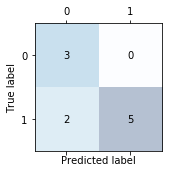

[[47  1]
 [ 7 35]]


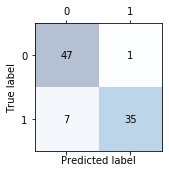

In [26]:
# Confusion matrix for test and train

from sklearn.metrics import confusion_matrix

#pipe_svc.fit(X_train, y_train)
#y_pred  = pipe_svc.predict(X_test)  # Predictins of test data 
#y_fit   = pipe_svc.predict(X_train) # Predictins (fitted values) of training data

clf     = pipe_svc.fit(X_train, y_train)
print('Train accuracy: %.3f' % clf.score(X_train, y_train))
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

y_pred  = clf.predict(X_test)  # Predictions of test data 
y_fit   = clf.predict(X_train) # Predictions (fitted values) of training data

confmat_test = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat_test)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat_test, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_test.shape[0]):
    for j in range(confmat_test.shape[1]):
        ax.text(x=j, y=i, s=confmat_test[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()


confmat_train = confusion_matrix(y_true=y_train, y_pred=y_fit)
print(confmat_train)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat_train, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_train.shape[0]):
    for j in range(confmat_train.shape[1]):
        ax.text(x=j, y=i, s=confmat_train[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

In [37]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)


0.8571428571428572